# **EIASR 21Z - Face Mask Detection**

We used this [project](https://www.kaggle.com/meghanatiyyali560/sailaja-meghana-project) as a guide how to use annotations provided with [image dataset we used](https://www.kaggle.com/andrewmvd/face-mask-detection). 

## **1. Environment preparation**

### Imports

In [ ]:
import os
import glob
import cv2
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras_preprocessing.image import ImageDataGenerator
from xml.etree import ElementTree
from pandas import DataFrame

### Constants

In [ ]:
path = 'drive/MyDrive/datasets/face-mask-detection'

BATCH_SIZE = 32
SEED_SIZE = 42
EPOCHS = 24
image_target_size = (24, 22)

key_cropped = 'cropped_image_file'
key_label = 'label'
key_file = 'file'
key_image_file = 'image_file'
key_annotation = 'annotation_file'

annotations_dir = path + '/annotations'
images_dir = path + '/images'
temp_dir = path + '/temp'
cropped_dir = temp_dir + '/cropped_images'

classifier_path = "drive/MyDrive/models/classifier.h5"

train_df_file_name = path + '/train_df.csv'
test_df_file_name = path + '/test_df.csv'

### Optional cleanup

In [ ]:
os.mkdir(temp_dir)
os.mkdir(cropped_dir)

!ls 'drive/MyDrive/datasets/face-mask-detection'
!ls 'drive/MyDrive/datasets/face-mask-detection/temp'

In [ ]:
shutil.rmtree(temp_dir)

In [ ]:
!ls 'drive/MyDrive/datasets/face-mask-detection'

annotations  images


## **2. Test dataset preparation**

### Read existing set

In [ ]:
train_df = pd.read_csv(train_df_file_name)
train_df

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file,cropped_image_file
0,308,88,322,103,with_mask,maksssksksss722,400,267,maksssksksss722.xml,maksssksksss722.png,maksssksksss722-800.png
1,131,86,259,216,with_mask,maksssksksss63,400,226,maksssksksss63.xml,maksssksksss63.png,maksssksksss63-801.png
2,168,65,234,139,with_mask,maksssksksss249,400,267,maksssksksss249.xml,maksssksksss249.png,maksssksksss249-802.png
3,309,119,368,191,without_mask,maksssksksss249,400,267,maksssksksss249.xml,maksssksksss249.png,maksssksksss249-803.png
4,223,89,266,146,without_mask,maksssksksss249,400,267,maksssksksss249.xml,maksssksksss249.png,maksssksksss249-804.png
...,...,...,...,...,...,...,...,...,...,...,...
3267,247,78,285,107,without_mask,maksssksksss703,400,267,maksssksksss703.xml,maksssksksss703.png,maksssksksss703-4067.png
3268,312,82,331,112,with_mask,maksssksksss703,400,267,maksssksksss703.xml,maksssksksss703.png,maksssksksss703-4068.png
3269,331,93,371,135,with_mask,maksssksksss703,400,267,maksssksksss703.xml,maksssksksss703.png,maksssksksss703-4069.png
3270,384,116,400,156,without_mask,maksssksksss703,400,267,maksssksksss703.xml,maksssksksss703.png,maksssksksss703-4070.png


### Prepare new dataset

In [ ]:
data = {'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 
        'label': [], 'file': [], 'width': [], 'height': []}

for annotation in glob.glob(annotations_dir + '/*.xml'):
    tree = ElementTree.parse(annotation)
    
    for element in tree.iter():
        if 'size' in element.tag:
            for attribute in list(element):
                if 'width' in attribute.tag:
                    width = int(round(float(attribute.text)))
                if 'height' in attribute.tag:
                    height = int(round(float(attribute.text)))

        if 'object' in element.tag:
            for attribute in list(element):
                if 'name' in attribute.tag:
                    name = attribute.text
                    data['label'] += [name]
                    data['width'] += [width]
                    data['height'] += [height]
                    data['file'] += [annotation.split('/')[-1][0:-4]]
                            
                if 'bndbox' in attribute.tag:
                    for dimension in list(attribute):
                        if 'xmin' in dimension.tag:
                            xmin = int(round(float(dimension.text)))
                            data['xmin'] += [xmin]
                        if 'ymin' in dimension.tag:
                            ymin = int(round(float(dimension.text)))
                            data['ymin'] += [ymin]                                
                        if 'xmax' in dimension.tag:
                            xmax = int(round(float(dimension.text)))
                            data['xmax'] += [xmax]                                
                        if 'ymax' in dimension.tag:
                            ymax = int(round(float(dimension.text)))
                            data['ymax'] += [ymax]


#### Crop images

In [ ]:
df = DataFrame(data)
df[key_annotation] = df[key_file] + '.xml'
df[key_image_file] = df[key_file] + '.png'
df[key_cropped] = df[key_file]

df

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file,cropped_image_file
0,23,114,77,172,mask_weared_incorrect,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11
1,147,157,200,211,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11
2,201,191,230,234,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11
3,243,192,293,247,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11
4,309,182,346,224,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11
...,...,...,...,...,...,...,...,...,...,...,...
4067,247,78,285,107,without_mask,maksssksksss703,400,267,maksssksksss703.xml,maksssksksss703.png,maksssksksss703
4068,312,82,331,112,with_mask,maksssksksss703,400,267,maksssksksss703.xml,maksssksksss703.png,maksssksksss703
4069,331,93,371,135,with_mask,maksssksksss703,400,267,maksssksksss703.xml,maksssksksss703.png,maksssksksss703
4070,384,116,400,156,without_mask,maksssksksss703,400,267,maksssksksss703.xml,maksssksksss703.png,maksssksksss703


In [ ]:
def crop(write=False):
  for i in range(len(df)):
      image_path = images_dir + '/' + df[key_image_file].iloc[i]
      
      df[key_cropped].iloc[i] = df[key_cropped].iloc[i] + '-' + str(i) + '.png'
      cropped_image_filename = df[key_cropped].iloc[i]
      
      xmin = df['xmin'].iloc[i]
      ymin = df['ymin'].iloc[i]
      xmax = df['xmax'].iloc[i]
      ymax = df['ymax'].iloc[i]
      
      if write:
        image = cv2.imread(image_path)
        cropped_image = image[ymin:ymax, xmin:xmax]
        cropped_image_dir = os.path.join(cropped_dir + '/', cropped_image_filename) 
        cv2.imwrite(cropped_image_dir, cropped_image)

In [ ]:
crop()

train_df = df[800:]
test_df = df[:800]

classes = list(train_df[key_label].unique())

In [ ]:
train_df.to_csv(train_df_file_name, encoding='utf-8', index=False)
test_df.to_csv(test_df_file_name, encoding='utf-8', index=False)

### Calculate image target size

In [ ]:
image_width = []
image_height = []

for i in range(len(train_df)):
    cropped_image_path = cropped_dir + '/' + train_df[key_cropped].iloc[i]
    cropped_image = cv2.imread(cropped_image_path)
    image_width.append(cropped_image.shape[0])
    image_height.append(cropped_image.shape[1])

In [ ]:
image_target_size = (int(np.median(image_width)), int(np.median(image_height)))
image_target_size

(24, 22)

### Dataset statistics

In [ ]:
sorted_label_df = DataFrame(train_df['label'].value_counts()).reset_index()
sorted_label_df.rename(columns = {'index': 'label', 'label': 'count'}, inplace = True)
sorted_label_df

,label,count
0,with_mask,2591
1,without_mask,580
2,mask_weared_incorrect,101


### Loading datasets

In [ ]:
training_image_generator = ImageDataGenerator(rescale = 1. / 255., 
                                              validation_split = 0.25)

training_generator = training_image_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = cropped_dir,
    x_col = key_cropped,
    y_col = key_label,
    subset = 'training',
    batch_size = BATCH_SIZE,
    seed = SEED_SIZE,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

validation_generator = training_image_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = cropped_dir,
    x_col = key_cropped,
    y_col = key_label,
    subset = 'validation',
    batch_size = BATCH_SIZE,
    seed = SEED_SIZE,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

Found 2454 validated image filenames belonging to 3 classes.
Found 818 validated image filenames belonging to 3 classes.


In [ ]:
input_shape = [int(np.median(image_width)), int(np.median(image_height)), 3]

## **3. Model preparation for transfer learning**

### Preparing ResNet50 model

In [ ]:
base_input_shape = (250, 250, 3)
weights = 'imagenet'

# without dense part
base_model = ResNet50V2(weights=weights, 
                        include_top=False, 
                        input_shape=base_input_shape)

94683136/94668760 [==============================] - 1s 0us/step


### Freezing base layers

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

### Adding Global Avg Pooling 2D and Dense layer

In [ ]:
num_classes = 3
activation = 'sigmoid' #'relu' 'softmax'

global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
outputs = keras.layers.Dense(num_classes, activation=activation)(global_avg_pooling)

classifier = keras.models.Model(inputs=base_model.inputs,
                                outputs=outputs,
                                name='ResNet50V2')

In [ ]:
classifier.summary()

Model: "ResNet50V2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

### Enable mechanisms preventing overlearning

In [ ]:
earlystop = EarlyStopping(monitor='val_loss',
                          restore_best_weights=True,
                          patience=3,
                          verbose=1)

### Enable mechanisms preventing interrupting learning process

In [ ]:
checkpoint = ModelCheckpoint(classifier_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

### Define training

In [ ]:
def train(learning_rate, showStats=False):
  callbacks = [earlystop, checkpoint]
  
  classifier.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=learning_rate),
                    metrics=['accuracy'])

  history = classifier.fit(training_generator,
                           epochs=EPOCHS,
                           steps_per_epoch=len(training_generator),
                           callbacks=callbacks,
                           validation_data=validation_generator,
                           validation_steps=len(validation_generator))

  classifier.save(classifier_path)

  if showStats:
    stats(history)

  return history

In [ ]:
def stats(history):
  # summarize history for accuracy
  plt.figure(figsize=(14,14))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.figure(figsize=(14,14))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

### Start training process (learning rate 1e-05)

In [ ]:
rate = 0.00001

Epoch 1/24
77/77 [==============================] - ETA: 0s - loss: 1.0743 - accuracy: 0.3663
Epoch 00001: val_loss improved from inf to 1.06883, saving model to drive/MyDrive/models/classifier.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


77/77 [==============================] - 796s 10s/step - loss: 1.0743 - accuracy: 0.3663 - val_loss: 1.0688 - val_accuracy: 0.3826
Epoch 2/24
77/77 [==============================] - ETA: 0s - loss: 1.0542 - accuracy: 0.4108
Epoch 00002: val_loss improved from 1.06883 to 1.05003, saving model to drive/MyDrive/models/classifier.h5
77/77 [==============================] - 18s 240ms/step - loss: 1.0542 - accuracy: 0.4108 - val_loss: 1.0500 - val_accuracy: 0.4340
Epoch 3/24
77/77 [==============================] - ETA: 0s - loss: 1.0353 - accuracy: 0.4617
Epoch 00003: val_loss improved from 1.05003 to 1.03230, saving model to drive/MyDrive/models/classifier.h5
77/77 [==============================] - 17s 222ms/step - loss: 1.0353 - accuracy: 0.4617 - val_loss: 1.0323 - val_accuracy: 0.4902
Epoch 4/24
77/77 [==============================] - ETA: 0s - loss: 1.0174 - accuracy: 0.5134
Epoch 00004: val_loss improved from 1.03230 to 1.01590, saving model to drive/MyDrive/models/classifier.h5
77

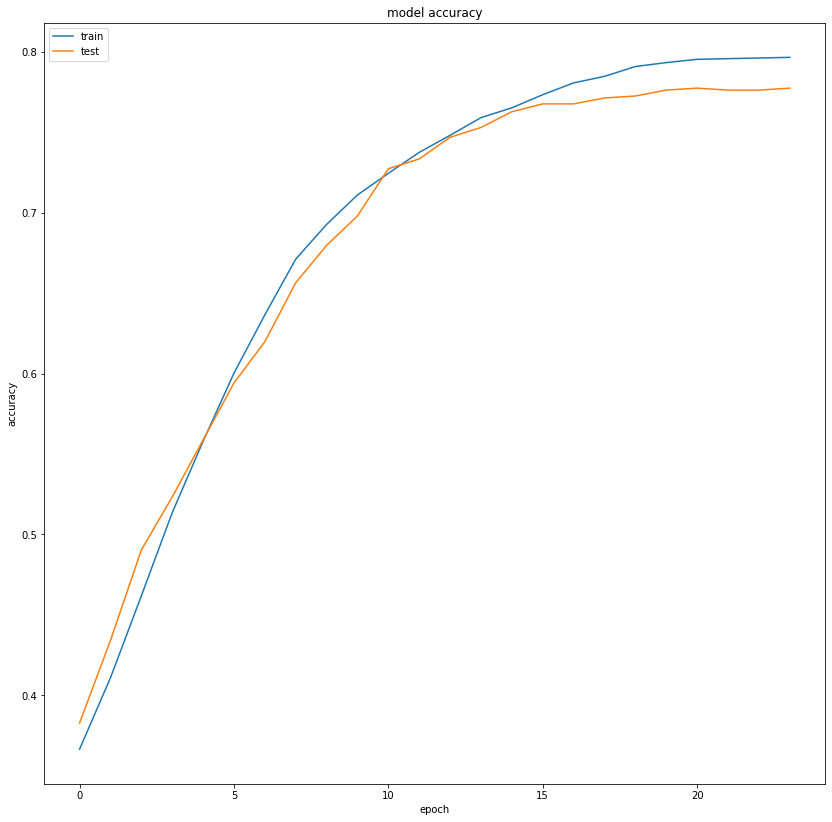

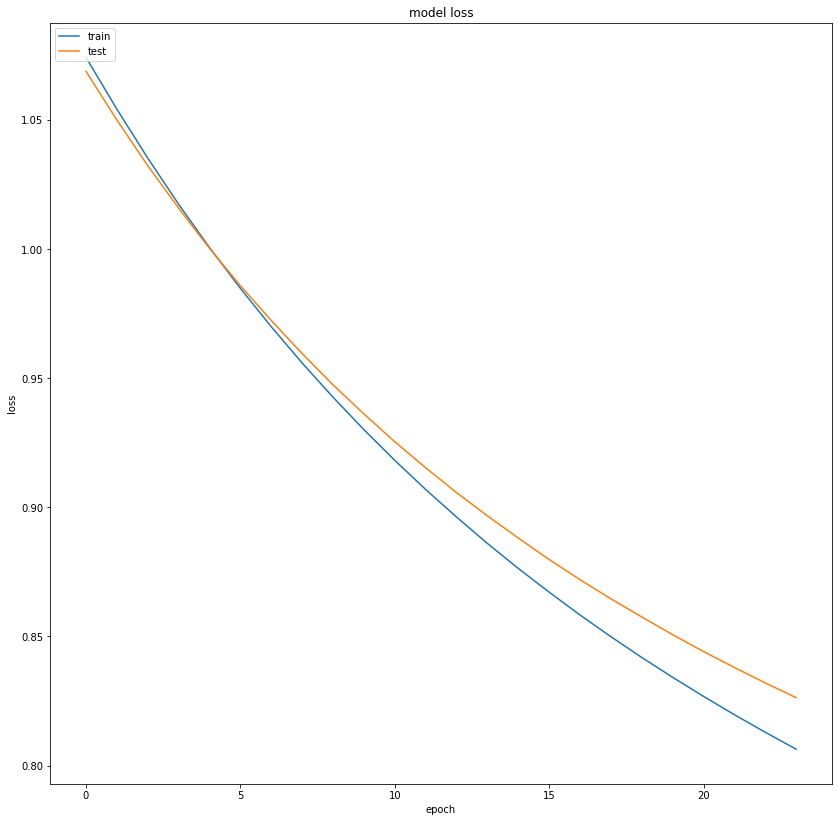

In [ ]:
history = train(rate, showStats=True)

In [ ]:
loss0, accuracy0 = classifier.evaluate(test_generator)

25/25 [==============================] - 4s 150ms/step - loss: 0.7874 - accuracy: 0.7912


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.79
initial accuracy: 0.79


In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  190


In [ ]:
def fine_tune(learning_rate, initialEpoch=1, showStats=False):
  callbacks = [earlystop, checkpoint]
  
  classifier.compile(loss='categorical_crossentropy',
                     optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate/10),
                     metrics=['accuracy'])

  fine_tune_epochs = 10
  total_epochs =  EPOCHS + fine_tune_epochs

  history = classifier.fit(training_generator,
                           epochs=total_epochs,
                           callbacks=callbacks,
                           initial_epoch=initialEpoch,
                           validation_data=validation_generator)

  classifier.save(classifier_path)

  if showStats:
    stats(history)

  return history

Epoch 24/34
77/77 [==============================] - ETA: 0s - loss: 0.9239 - accuracy: 0.6145
Epoch 00024: val_loss did not improve from 0.82626
77/77 [==============================] - 167s 2s/step - loss: 0.9239 - accuracy: 0.6145 - val_loss: 0.8632 - val_accuracy: 0.7127
Epoch 25/34
77/77 [==============================] - ETA: 0s - loss: 0.9215 - accuracy: 0.6410
Epoch 00025: val_loss did not improve from 0.82626
77/77 [==============================] - 159s 2s/step - loss: 0.9215 - accuracy: 0.6410 - val_loss: 0.9431 - val_accuracy: 0.6858
Epoch 26/34
77/77 [==============================] - ETA: 0s - loss: 0.9325 - accuracy: 0.6284
Epoch 00026: val_loss did not improve from 0.82626
77/77 [==============================] - 161s 2s/step - loss: 0.9325 - accuracy: 0.6284 - val_loss: 0.9525 - val_accuracy: 0.6528
Epoch 27/34
77/77 [==============================] - ETA: 0s - loss: 0.9229 - accuracy: 0.6398Restoring model weights from the end of the best epoch: 24.

Epoch 00027: val_

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


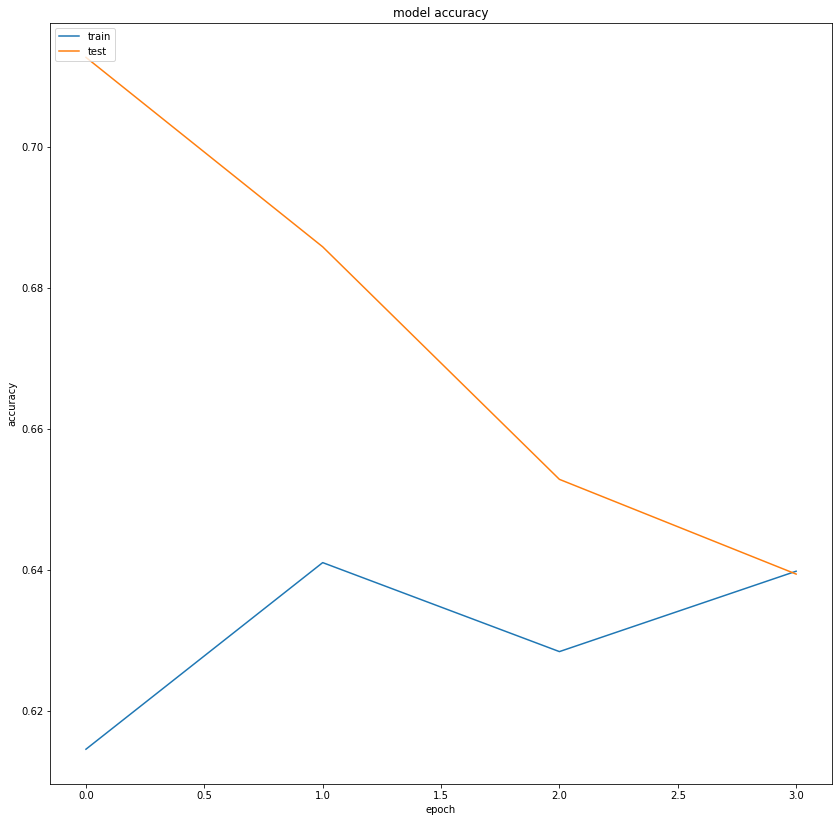

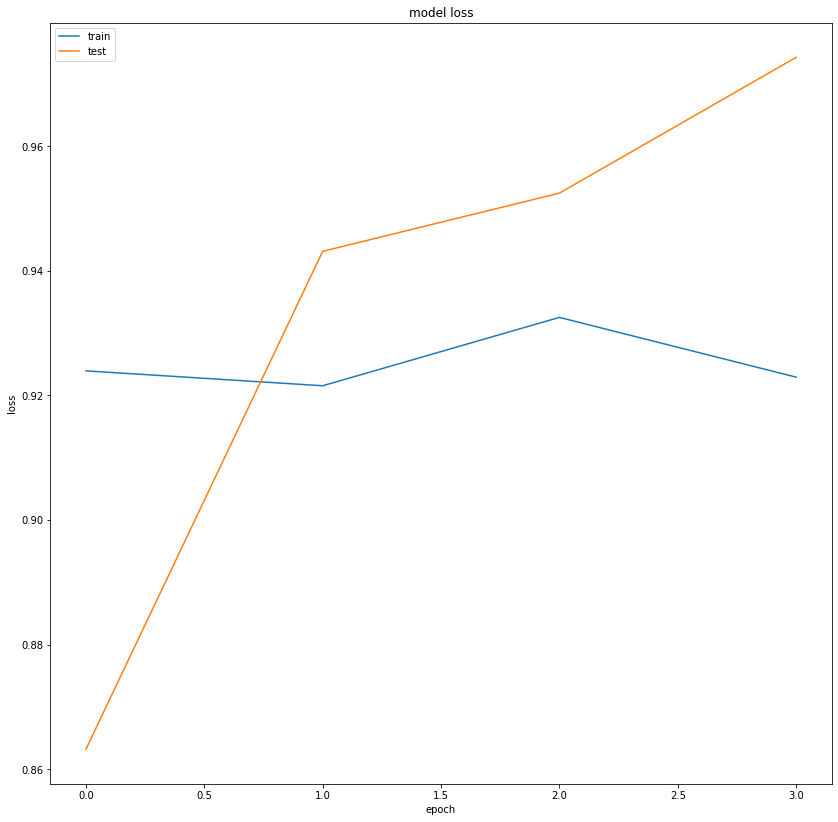

In [ ]:
fine_tune(rate, history.epoch[-1], True)

In [ ]:
loss1, accuracy1 = classifier.evaluate(test_generator)

25/25 [==============================] - 4s 151ms/step - loss: 0.8096 - accuracy: 0.7437


In [ ]:
print("initial loss: {:.2f}".format(loss1))
print("initial accuracy: {:.2f}".format(accuracy1))

initial loss: 0.81
initial accuracy: 0.74


## **4. Results evaluation**

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from pandas import DataFrame
from keras_preprocessing.image import ImageDataGenerator

from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
# load model
model = tf.keras.models.load_model(classifier_path)

In [ ]:
# ..or use classifier reference if it is possible
model = classifier

In [ ]:
test_df = pd.read_csv(test_df_file_name)
test_df

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file,cropped_image_file
0,23,114,77,172,mask_weared_incorrect,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-0.png
1,147,157,200,211,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-1.png
2,201,191,230,234,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-2.png
3,243,192,293,247,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-3.png
4,309,182,346,224,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-4.png
...,...,...,...,...,...,...,...,...,...,...,...
795,175,80,193,103,with_mask,maksssksksss722,400,267,maksssksksss722.xml,maksssksksss722.png,maksssksksss722-795.png
796,158,83,170,99,with_mask,maksssksksss722,400,267,maksssksksss722.xml,maksssksksss722.png,maksssksksss722-796.png
797,210,93,224,108,with_mask,maksssksksss722,400,267,maksssksksss722.xml,maksssksksss722.png,maksssksksss722-797.png
798,244,93,252,104,with_mask,maksssksksss722,400,267,maksssksksss722.xml,maksssksksss722.png,maksssksksss722-798.png


In [ ]:
sorted_label_df = DataFrame(test_df['label'].value_counts()).reset_index()
sorted_label_df.rename(columns = {'index': 'label', 'label': 'count'}, inplace = True)
sorted_label_df

,label,count
0,with_mask,641
1,without_mask,137
2,mask_weared_incorrect,22


In [ ]:
image_target_size = (24, 22)

test_image_generator = ImageDataGenerator(rescale = 1. / 255.)
test_generator = test_image_generator.flow_from_dataframe(
    dataframe = test_df,
    directory = cropped_dir,
    x_col = key_cropped,
    y_col = key_label,
    batch_size = BATCH_SIZE,
    seed = SEED_SIZE,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

Found 800 validated image filenames belonging to 3 classes.


In [ ]:
generator = test_generator
generator.reset()

pred = model.predict(generator, 
                     batch_size=BATCH_SIZE,
                     steps=len(generator), 
                     verbose=1)

25/25 [==============================] - 5s 154ms/step


In [ ]:
y_pred = np.argmax(pred, axis=1)

In [ ]:
print('Score Report')
lin_score = accuracy_score(generator.labels, y_pred)
lin_score

Score Report


0.72125

In [ ]:
y_pred = np.argmax(pred, axis=1)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Confusion Matrix


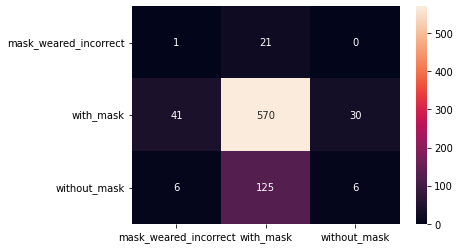

In [ ]:
print('Confusion Matrix')

label_names = ['mask_weared_incorrect', 'with_mask', 'without_mask']
matrix = confusion_matrix(generator.classes, y_pred)
sns.heatmap(matrix,
            annot = True,
            fmt='g',
            xticklabels=label_names,
            yticklabels=label_names)

In [ ]:
print('Classification Report')
print(classification_report(generator.classes, y_pred, target_names=label_names))

Classification Report
                       precision    recall  f1-score   support

mask_weared_incorrect       0.02      0.05      0.03        22
            with_mask       0.80      0.89      0.84       641
         without_mask       0.17      0.04      0.07       137

             accuracy                           0.72       800
            macro avg       0.33      0.33      0.31       800
         weighted avg       0.67      0.72      0.69       800

